This notebook was inspired by neural network & machine learning labs led by [GMUM](https://gmum.net/).

See also [Chapter 14](https://www.deeplearningbook.org/contents/autoencoders.html) of the Deep Learning book, Lilian Weng's [From Autoencoder to Beta-VAE](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html), and the [DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

Utils and imports (run and hide).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import Subset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor, Lambda, Compose

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def plot_dataset(train_data, model):
    view_data = train_data.data[:5].view(-1, 28*28) / 255.
    _, decoded_data = model.forward(train_data.data[:5].view(-1, 784).float().to(device) / 255.)
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    plt.suptitle("Reconstruction")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())
        
        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap='gray')
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())
    
    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[i].set_xticks(())
            axes[i].set_yticks(())
    
    plt.show()
    
def plot_pca(data, model):
    labels = data.classes
    plt.suptitle("Reduction of latent space")
    plt.figure(figsize=(10, 6))
    pca = PCA(2)

    z = model.encode(train_data.data.view(-1, 784).float().to(device))
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())
    
    for class_idx in range(10):
        indices = (data.targets == class_idx)
        plt.scatter(
            reduced_z[indices, 0], reduced_z[indices, 1],
            s=2., label=labels[class_idx])

    plt.legend()
    plt.show()

    
torch.manual_seed(1337) 
batch_size = 128 
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

train_data = MNIST(root='.', 
                   train=True, 
                   transform=transforms,    
                   download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

## Discriminative vs. generative models

There are (generally) two approaches to statistical classification:
- *generative*, where we model the joint probability distribution $P(X,Y)$,
- *discriminative*, where we model the conditional probability of the target $Y$ given an observation $x$, $P(Y\vert X=x)$ (classifiers computed without using a probability model are also loosely referred to as "discriminative").

One can also think of generative models as learning the distribution of individual classes and discriminative models as learning (hard or soft) boundaries between classes.

Generative models allow you to generate data similar to training data, whereas discriminative models might be easier to learn.

See the [Wikipedia article](https://en.wikipedia.org/wiki/Generative_model) on generative models, the [CrossValidated question](https://stats.stackexchange.com/questions/12421/generative-vs-discriminative), and the classic ML paper [On Discriminative vs. Generative Classifiers: A comparison of logistic regression and naive Bayes](https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf) for more disambiguation.

Today we will work with the autoencoder model, first showing how to use it for semi-supervised learning, and later building a generative model.

## Vanilla autoencoder

An *autoencoder* is a neural network that is trained to copy it's input to its output. The network may be viewed as consisting of two parts: an *encoder* $g_\phi$, which takes in an input $\mathbf{x}$ and produces a *code* (also: *hidden representation*; *latent vector*) $\mathbf{z}=g_\phi(\mathbf{x})$ , and the *decoder* $f_\theta$, which produces a reconstruction $\mathbf{x'}=f_\theta(\mathbf{z})$.

![auto-encoder](figures/ae.png)
<center>Source: <a href="https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html">From Autoencoder to Beta-VAE</a>.</center>

If an autoencoder succeeds in simply learning to set $f_\theta(g_\phi(\mathbf{x}))=\mathbf{x}$ everywhere, then it is not especially useful. Instead, autoencoders are designed to be unable to learn to copy perfectly. Because the model is forced to prioritize which aspects of the input should be copied, it often learns useful properties of the data.

The loss function for the vanilla autoencoder is the MSE between the input and output:
$$L_{AE} =\frac{1}{n}\sum_i \lVert\mathbf{x}_i-f_\theta(g_\phi(\mathbf{x}_i))\rVert_2^2.$$
The encoder and the decoder can be arbitrary neural networks, but usually the decoder is comprised of the same transformations as the encoder in reverse order.  

## Task 1 (0.25p)
Implement the encoder and the decoder for a vanilla autoencoder. 

The dimensions in the encoder are supposed to have the following number of neurons: `(784, 128, 128, 64, latent_dim)`. Analogously, for the decoder: `(latent_dim, 64, 128, 128, 784)`. (The input and output dimensionality corresponds to the number of pixels in MNIST.) `latent_dim` is supposed to be a parameter of the constructor.

Use no activation function after the encoder, a sigmoid after the decoder, and ReLU after the hidden layers.

In [2]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim):
        
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.latent_dim),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28*28),
            torch.nn.Sigmoid(),    
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, encoded):
        return self.decoder(encoded)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

Epoch: 1  |  train loss: 0.0502


<Figure size 432x288 with 0 Axes>

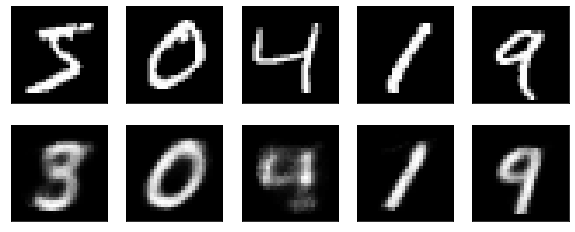

<Figure size 432x288 with 0 Axes>

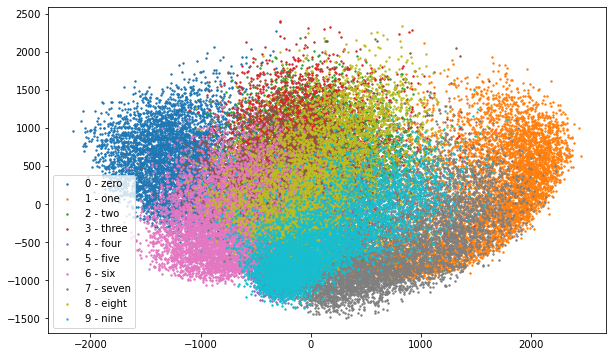

Epoch: 2  |  train loss: 0.0285
Epoch: 3  |  train loss: 0.0242
Epoch: 4  |  train loss: 0.0216
Epoch: 5  |  train loss: 0.0195
Epoch: 6  |  train loss: 0.0183
Epoch: 7  |  train loss: 0.0176
Epoch: 8  |  train loss: 0.0171
Epoch: 9  |  train loss: 0.0168
Epoch: 10  |  train loss: 0.0165
Epoch: 11  |  train loss: 0.0163


<Figure size 432x288 with 0 Axes>

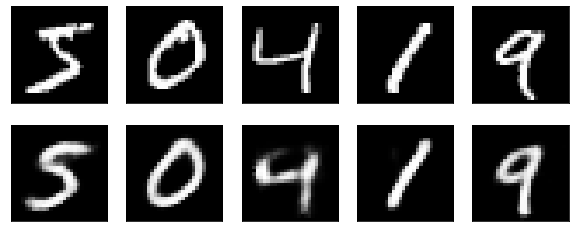

<Figure size 432x288 with 0 Axes>

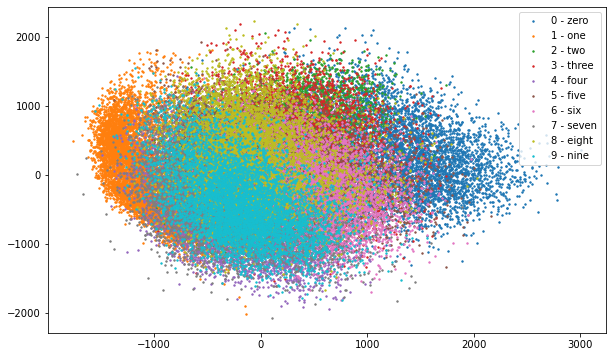

Epoch: 12  |  train loss: 0.0161
Epoch: 13  |  train loss: 0.0159
Epoch: 14  |  train loss: 0.0158
Epoch: 15  |  train loss: 0.0157
Epoch: 16  |  train loss: 0.0156
Epoch: 17  |  train loss: 0.0155
Epoch: 18  |  train loss: 0.0154
Epoch: 19  |  train loss: 0.0153
Epoch: 20  |  train loss: 0.0153
Epoch: 21  |  train loss: 0.0151


<Figure size 432x288 with 0 Axes>

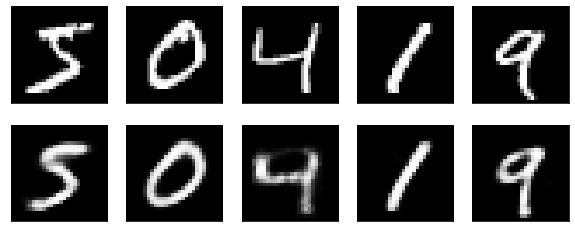

<Figure size 432x288 with 0 Axes>

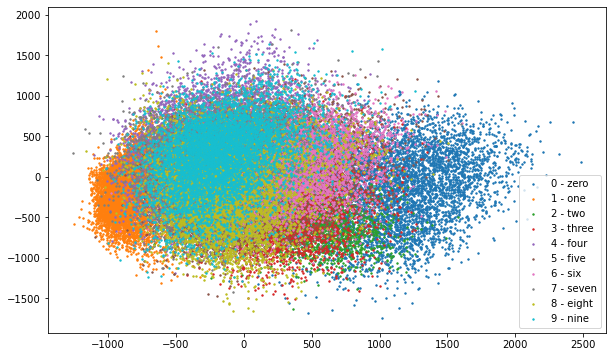

Epoch: 22  |  train loss: 0.0151
Epoch: 23  |  train loss: 0.0150
Epoch: 24  |  train loss: 0.0150
Epoch: 25  |  train loss: 0.0149


In [3]:
n_epochs = 25
lr = 5e-3        

autoencoder = AutoEncoder(latent_dim=10).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

for epoch in range(n_epochs):
    epoch_losses = []  
    for step, (x, _) in enumerate(train_loader):
        
        x = x.to(device)
        
        optimizer.zero_grad()        

        _, decoded = autoencoder(x) 
        loss = criterion(decoded, x)   
        loss.backward()          
        optimizer.step()            
        
        epoch_losses.append(loss.item())

    print(f'Epoch: {epoch+1}  |  train loss: {np.mean(epoch_losses):.4f}')

    if epoch % 10 == 0:
        plot_dataset(train_data, autoencoder)
        plot_pca(train_data, autoencoder)

## Semi-supervised learning

In practice building a fully-labeled dataset can be very costly. If we want to train an image classifier, then gathering a large amount of data isn't a problem (we can scrape them from the internet, for example). Labelling them, however, is, and would require human resources. In some cases, labelling can be even more expensive -- in the segmentation task, where we want to assign a class to each pixel in the image, assigning the labels for one picture can take many hours.

Thus, we'd like to have methods which are able to utilize data for which we don't have labels. In the following task we'll build a simple semi-supervised model using an autoencoder.

## Task 2 (0.5p)

Assume that for the 60k examples from MNIST only 100 have the label. The 100 labeled examples are in the variable `labeled_data`.

1. Implement a classifier and train it on the 100 labeled examples. Report the accuracy on the test set. (The net should be relatively simple: max. 4 layers, max. 128 neurons in a layer).
2. Implement a classifier and train it on the 100 labeled examples with a similar architecture to the previous subtask, only that this time the input to the network will be the hidden representation $\mathbf{z}=g_\phi(\mathbf{x})$ created by the autoencoder in Task 1. Report the accuracy on the test set.
3. Compare the results of both models. Which model performed better? Do you have any hypotheses as to why?

In [4]:
labeled_data = Subset(train_data, range(100))
labeled_loader = torch.utils.data.DataLoader(dataset=labeled_data, batch_size=32, shuffle=True)

test_data = MNIST(root='.', 
                   train=False, 
                   transform=transforms,    
                   download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=True)

In [5]:
# implement and train the baseline model here
n_epochs = 100
lr = 0.005         

classifier = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

classifier = classifier.to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def evaluate(classifier, loader):
    correct_n = 0
    all_n = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds = classifier(x).argmax(-1)
        correct_n += (preds == y).float().sum().item()
        all_n += len(y)
    return correct_n / all_n

for epoch in range(n_epochs):
    epoch_losses = []
    for step, (x, y) in enumerate(labeled_loader):
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()        
               
        pred = classifier(x)
        loss = criterion(pred, y) 
        loss.backward()    
        optimizer.step()        

        epoch_losses.append(loss.item())

    acc = evaluate(classifier, test_loader)
    print(f'Epoch: {epoch+1}, | train loss: {np.mean(epoch_losses):.4f} | test acc {acc:.4f}')

Epoch: 1, | train loss: 2.1962 | test acc 0.4903
Epoch: 2, | train loss: 1.4895 | test acc 0.4940
Epoch: 3, | train loss: 1.2107 | test acc 0.5845
Epoch: 4, | train loss: 0.8540 | test acc 0.5730
Epoch: 5, | train loss: 0.4543 | test acc 0.6230
Epoch: 6, | train loss: 0.2971 | test acc 0.6062
Epoch: 7, | train loss: 0.2084 | test acc 0.6310
Epoch: 8, | train loss: 0.0969 | test acc 0.5952
Epoch: 9, | train loss: 0.0640 | test acc 0.6129
Epoch: 10, | train loss: 0.0291 | test acc 0.6550
Epoch: 11, | train loss: 0.0243 | test acc 0.6677
Epoch: 12, | train loss: 0.0085 | test acc 0.6698
Epoch: 13, | train loss: 0.0038 | test acc 0.6682
Epoch: 14, | train loss: 0.0034 | test acc 0.6662
Epoch: 15, | train loss: 0.0024 | test acc 0.6661
Epoch: 16, | train loss: 0.0018 | test acc 0.6697
Epoch: 17, | train loss: 0.0012 | test acc 0.6741
Epoch: 18, | train loss: 0.0009 | test acc 0.6772
Epoch: 19, | train loss: 0.0009 | test acc 0.6804
Epoch: 20, | train loss: 0.0010 | test acc 0.6822
Epoch: 21

In [6]:
# implement and train the model based on the representation produced by the autoencoder here

n_epochs = 100
lr = 0.005

classifier = nn.Sequential(
    nn.Linear(10, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

classifier = classifier.to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def evaluate(ae, classifier, loader):
    correct_n = 0
    all_n = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        encoded = ae.encode(x)
        preds = classifier(encoded).argmax(-1)
        correct_n += (preds == y).float().sum().item()
        all_n += len(y)
    return correct_n / all_n      

for epoch in range(n_epochs):
    epoch_losses = []
    for step, (x, y) in enumerate(labeled_loader):
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        encoded = autoencoder.encode(x) 
        pred = classifier(encoded)
        loss = criterion(pred, y) 
        loss.backward()         
        optimizer.step()      

        epoch_losses.append(loss.item())

    acc = evaluate(autoencoder, classifier, test_loader)
    print(f'Epoch: {epoch+1}, | train loss: {np.mean(epoch_losses):.4f} | test acc {acc:.4f}')

Epoch: 1, | train loss: 2.0586 | test acc 0.4867
Epoch: 2, | train loss: 1.3443 | test acc 0.5193
Epoch: 3, | train loss: 0.9491 | test acc 0.6531
Epoch: 4, | train loss: 0.5509 | test acc 0.7274
Epoch: 5, | train loss: 0.3263 | test acc 0.7273
Epoch: 6, | train loss: 0.2586 | test acc 0.7519
Epoch: 7, | train loss: 0.1265 | test acc 0.7608
Epoch: 8, | train loss: 0.0894 | test acc 0.7517
Epoch: 9, | train loss: 0.0764 | test acc 0.7636
Epoch: 10, | train loss: 0.0634 | test acc 0.7548
Epoch: 11, | train loss: 0.0334 | test acc 0.7388
Epoch: 12, | train loss: 0.0280 | test acc 0.7429
Epoch: 13, | train loss: 0.0169 | test acc 0.7571
Epoch: 14, | train loss: 0.0135 | test acc 0.7673
Epoch: 15, | train loss: 0.0098 | test acc 0.7721
Epoch: 16, | train loss: 0.0089 | test acc 0.7721
Epoch: 17, | train loss: 0.0075 | test acc 0.7738
Epoch: 18, | train loss: 0.0053 | test acc 0.7717
Epoch: 19, | train loss: 0.0050 | test acc 0.7711
Epoch: 20, | train loss: 0.0042 | test acc 0.7718
Epoch: 21

[your answer here]

## Generative models

Neural-net based generative models allow us to [generate new faces](https://thispersondoesnotexist.com/) or [generate text](https://transformer.huggingface.co/doc/gpt2-large). The next task will involve creating a generative autoencoder and training it on the FashionMNIST dataset. 

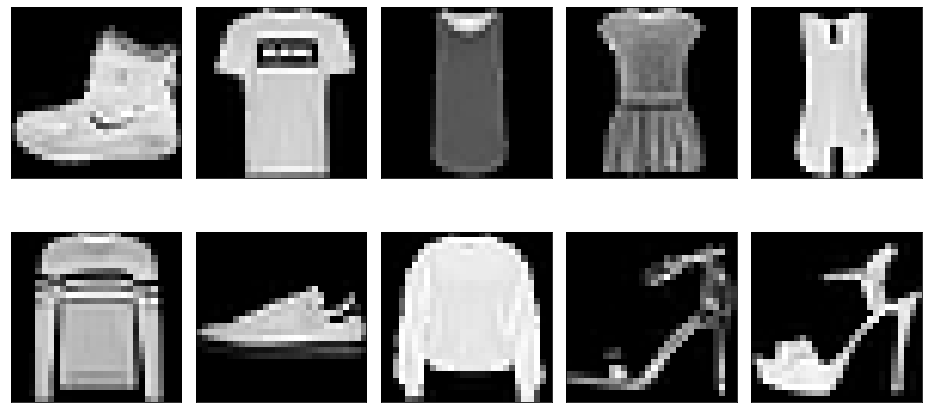

In [7]:
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root='.', 
                          train=True, 
                          transform=transforms,
                          download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 

fig, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap='gray')
    ax.set_xticks(())
    ax.set_yticks(())
fig.tight_layout()
plt.show()

## Wasserstein Autoencoder
The Wasserstein Autoencoder is identical in architecture to the vanilla one, with the additional constraint that the codes in the latent space are to form a normal distribution. Thanks to this we'll be able to generate new examples by sampling noise from the normal distribution and sending it through the decoder.

The loss function is comprised of two parts; the reconstruction loss and a distance between probability distributions:
$$L_{WAE-MMD} =\frac{1}{n}\sum_i \lVert\mathbf{x}_i-f_\theta(g_\phi(\mathbf{x}_i))\rVert_2^2+C\cdot \text{MMD}(g_\phi(\mathbf{x}_i),(\mathbf{y}_j)),$$
where $\mathbf{y}_j$ are samples from the normal distribution $\mathcal{N}(0, I)$, and $C \in \mathbb{R}$ is hyperparameter which weights the different components of the cost function.

The formula for Maximum Mean Discrepancy is as follows:
$$\text{MMD}((\mathbf{y}_i),(\mathbf{z}_j))=\frac{1}{n^2}\sum_{i,i'}k(\mathbf{y}_i,\mathbf{y}_{i'})+\frac{1}{n^2}\sum_{j,j'}k(\mathbf{z}_j,\mathbf{z}_{j'})-\frac{2}{n^2}\sum_{i,j}k(\mathbf{y}_i,\mathbf{z}_j),$$
where $k$ is a kernel function.

MMD describes a distance between the hidden representation $\mathbf{z}=g_\phi(\mathbf{x})$, obtained by passing the training examples through the encoder, and samples $\mathbf{y}_j\sim\mathcal{N}(0, I)$. Minimizing this cost will make the distribution produced by the encoder be more like the normal distribution, which is what we want to achieve.

We will use the IMQ (inverse multi-quadratic) kernel:
$$k(\mathbf{y}, \mathbf{z})=\frac{\sigma}{\sigma+\lvert\mathbf{y} - \mathbf{z} \rvert^2},$$
where $\sigma$ is a hyperparameter you need to find.

## Task 3 (1p)
Implement the Wasserstein Autoencoder with the Maximum Mean Discrepancy loss component.

1. Implement the autoencoder architecture (encoder + decoder) as in Task 1. The architecture should take into account that FashionMNIST is more complicated than MNIST (e.g. use 50 dimensions for the latent space).
2. Implement a training loop for WAE, where we minimize the loss function $L_{WAE-MMD}$.
3. Find hypeparameters (learning rate, number of training epochs, $C$, $\sigma$, etc.), so that the reconstruction and generated samples look decent (use the `plot_samples` function below). (Start from $C=1$, $\sigma=2D$, where $D$ is the dimensionality of the latent space.)

Cf. [the paper](https://arxiv.org/abs/1711.01558) and [the official implementation](https://github.com/tolstikhin/wae).

In [8]:
def plot_samples(model):
    sampled_z = torch.randn(20, model.latent_dim).to(device)
    generated = model.decode(sampled_z)

    generated = generated.cpu().detach().numpy()
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
        ax.set_xticks(())
        ax.set_yticks(())
    fig.tight_layout()
    fig.suptitle("Generated samples")
    plt.show()

In [9]:
class WAEMMD(nn.Module):
    
    def __init__(self, latent_dim):
        
        super(WAEMMD, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, encoded):
        return self.decoder(encoded)
    
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded
    
    def mmd_loss(self, y, sigma):
        z = torch.randn(y.size(0), self.latent_dim).to(y.device)

        yy_dist = (y.unsqueeze(0) - y.unsqueeze(1)).square().sum(-1)
        zz_dist = (z.unsqueeze(0) - z.unsqueeze(1)).square().sum(-1)
        yz_dist = (y.unsqueeze(0) - z.unsqueeze(1)).square().sum(-1)


        yy_term = sigma / (sigma + yy_dist)
        zz_term = sigma / (sigma + zz_dist)
        yz_term = sigma / (sigma + yz_dist)

        return (yy_term - 2 * yz_term + zz_term).mean()

Epoch: 1 | train loss: 0.06962


<Figure size 432x288 with 0 Axes>

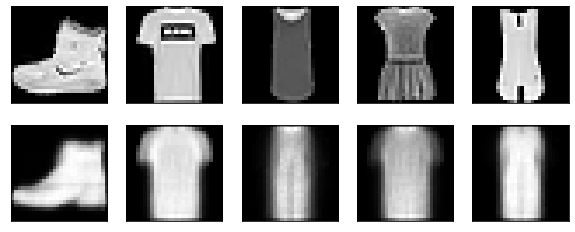

<Figure size 432x288 with 0 Axes>

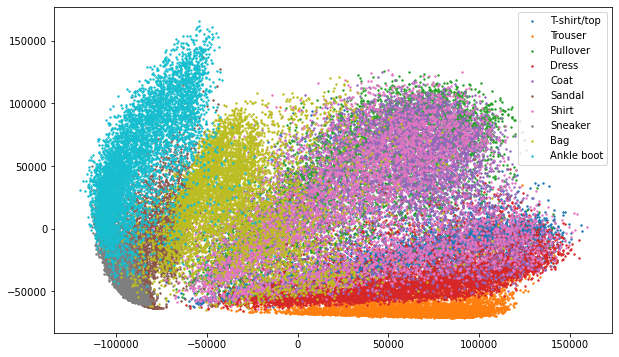

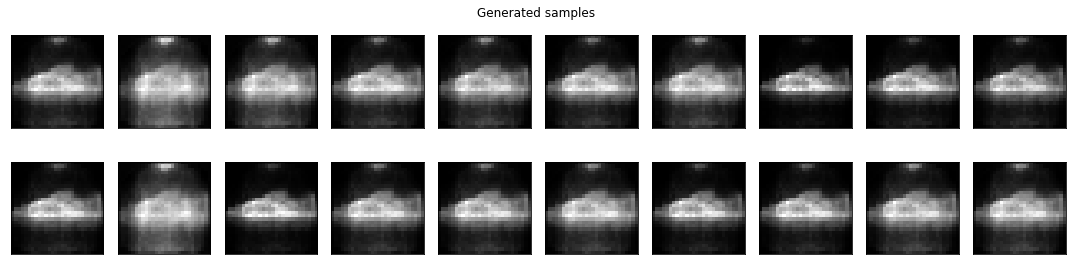

Epoch: 2 | train loss: 0.04349
Epoch: 3 | train loss: 0.03697
Epoch: 4 | train loss: 0.03460
Epoch: 5 | train loss: 0.03222
Epoch: 6 | train loss: 0.02956
Epoch: 7 | train loss: 0.02811
Epoch: 8 | train loss: 0.02697
Epoch: 9 | train loss: 0.02596
Epoch: 10 | train loss: 0.02507
Epoch: 11 | train loss: 0.02431


<Figure size 432x288 with 0 Axes>

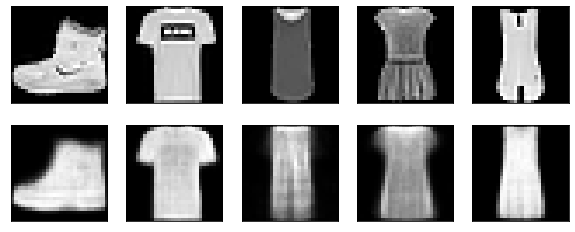

<Figure size 432x288 with 0 Axes>

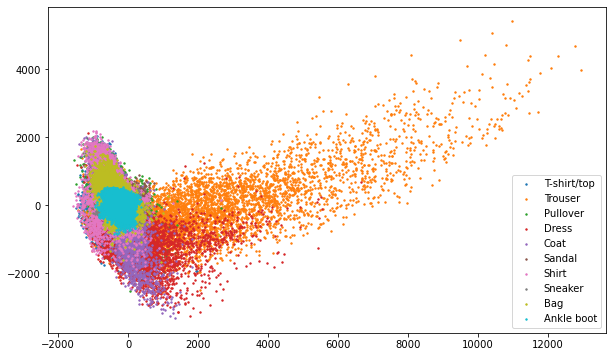

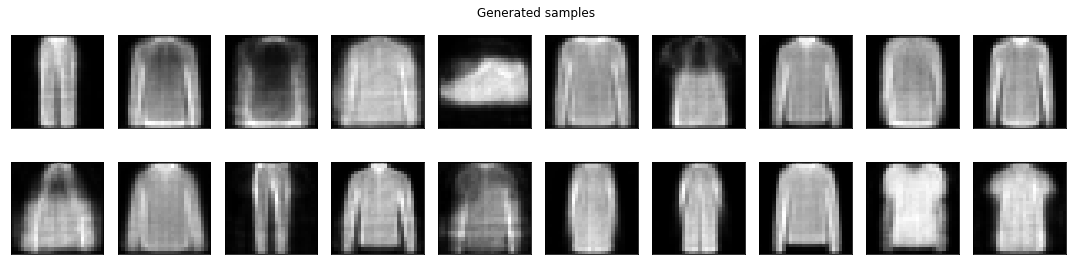

Epoch: 12 | train loss: 0.02392
Epoch: 13 | train loss: 0.02342
Epoch: 14 | train loss: 0.02310
Epoch: 15 | train loss: 0.02270
Epoch: 16 | train loss: 0.02250
Epoch: 17 | train loss: 0.02227
Epoch: 18 | train loss: 0.02206
Epoch: 19 | train loss: 0.02178
Epoch: 20 | train loss: 0.02176
Epoch: 21 | train loss: 0.02162


<Figure size 432x288 with 0 Axes>

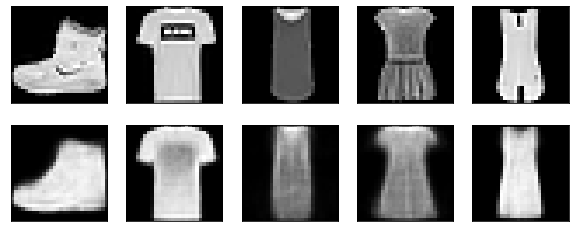

<Figure size 432x288 with 0 Axes>

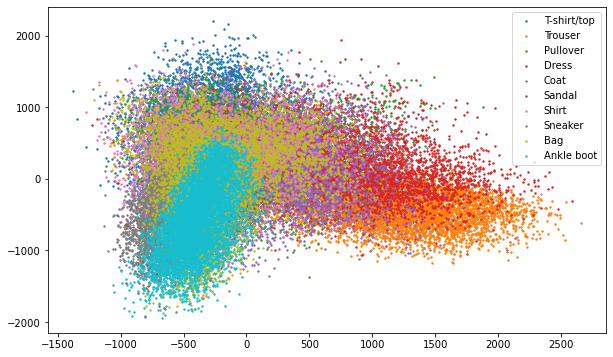

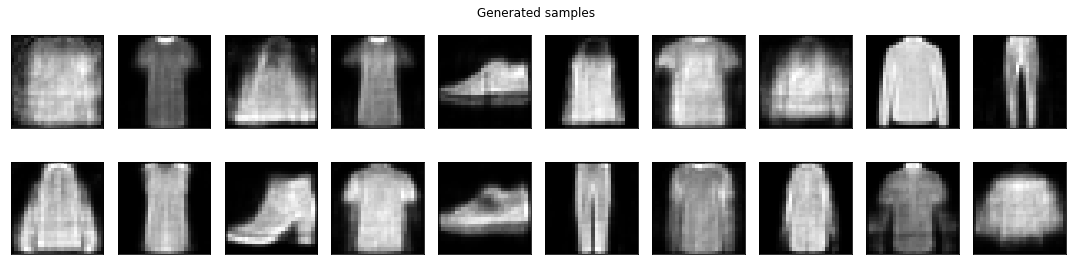

Epoch: 22 | train loss: 0.02144
Epoch: 23 | train loss: 0.02135
Epoch: 24 | train loss: 0.02124
Epoch: 25 | train loss: 0.02126
Epoch: 26 | train loss: 0.02116
Epoch: 27 | train loss: 0.02100
Epoch: 28 | train loss: 0.02087
Epoch: 29 | train loss: 0.02085
Epoch: 30 | train loss: 0.02092
Epoch: 31 | train loss: 0.02082


<Figure size 432x288 with 0 Axes>

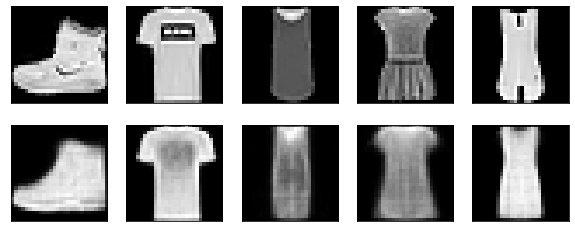

<Figure size 432x288 with 0 Axes>

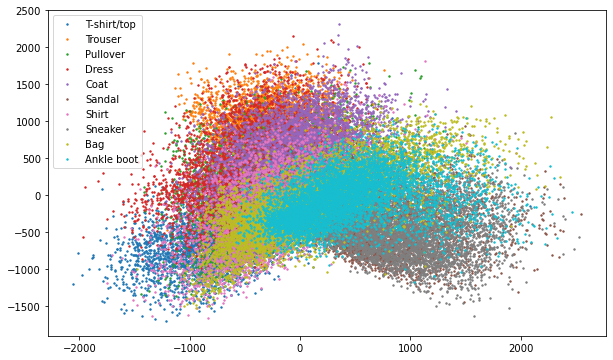

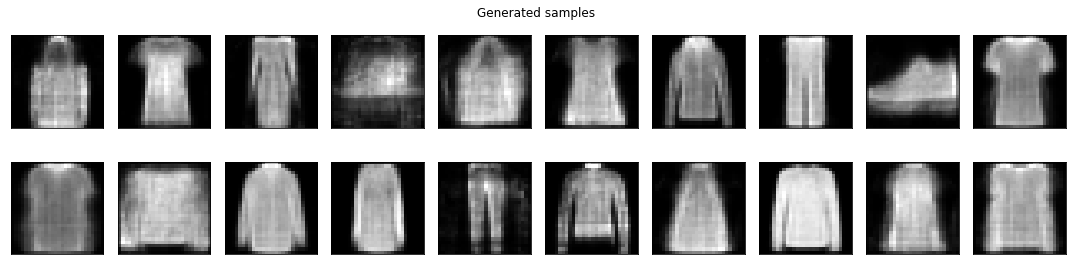

Epoch: 32 | train loss: 0.02069
Epoch: 33 | train loss: 0.02061
Epoch: 34 | train loss: 0.02058
Epoch: 35 | train loss: 0.02055
Epoch: 36 | train loss: 0.02049
Epoch: 37 | train loss: 0.02047
Epoch: 38 | train loss: 0.02038
Epoch: 39 | train loss: 0.02045
Epoch: 40 | train loss: 0.02029
Epoch: 41 | train loss: 0.02029


<Figure size 432x288 with 0 Axes>

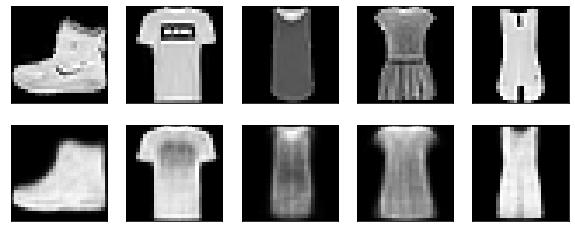

<Figure size 432x288 with 0 Axes>

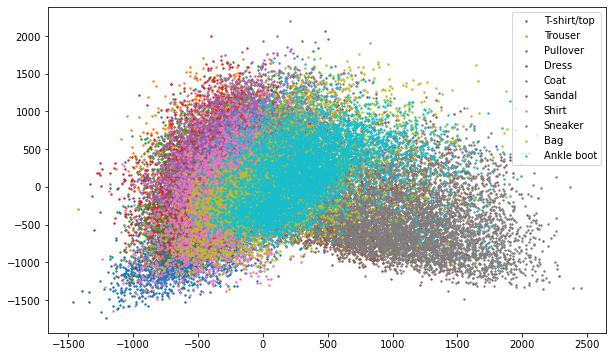

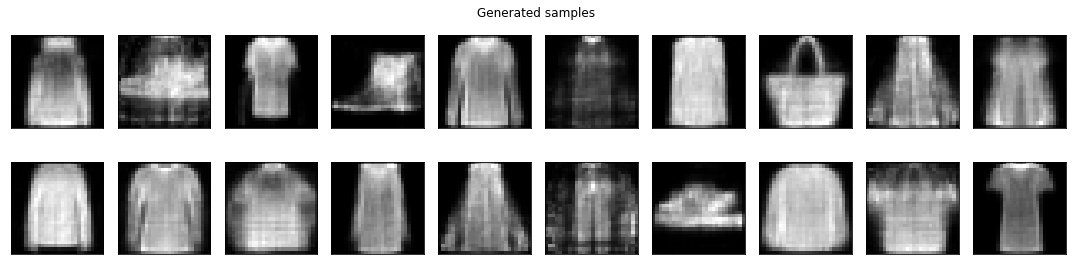

Epoch: 42 | train loss: 0.02013
Epoch: 43 | train loss: 0.02010
Epoch: 44 | train loss: 0.02016
Epoch: 45 | train loss: 0.02008
Epoch: 46 | train loss: 0.02016
Epoch: 47 | train loss: 0.01995
Epoch: 48 | train loss: 0.01996
Epoch: 49 | train loss: 0.02000
Epoch: 50 | train loss: 0.01995
Epoch: 51 | train loss: 0.01991


<Figure size 432x288 with 0 Axes>

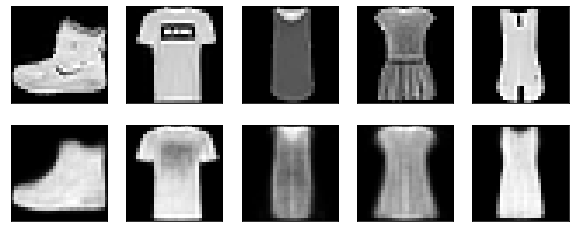

<Figure size 432x288 with 0 Axes>

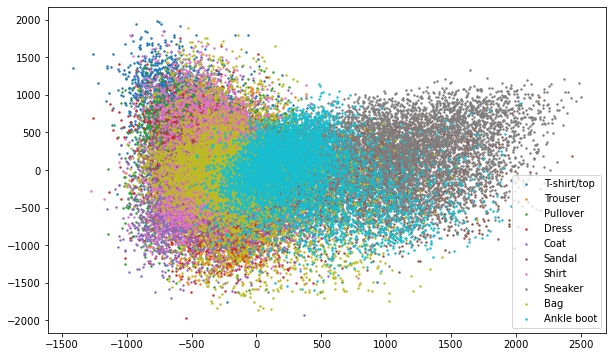

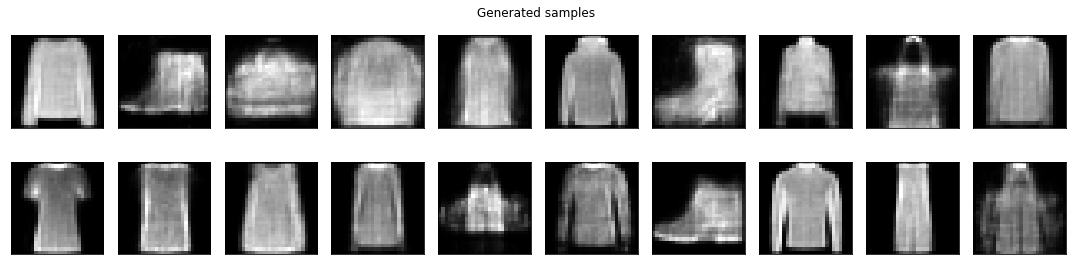

Epoch: 52 | train loss: 0.01987
Epoch: 53 | train loss: 0.01985
Epoch: 54 | train loss: 0.01986
Epoch: 55 | train loss: 0.01978
Epoch: 56 | train loss: 0.01981
Epoch: 57 | train loss: 0.01972
Epoch: 58 | train loss: 0.01975
Epoch: 59 | train loss: 0.01965
Epoch: 60 | train loss: 0.01967
Epoch: 61 | train loss: 0.01969


<Figure size 432x288 with 0 Axes>

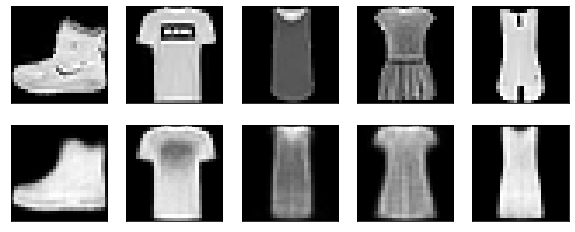

<Figure size 432x288 with 0 Axes>

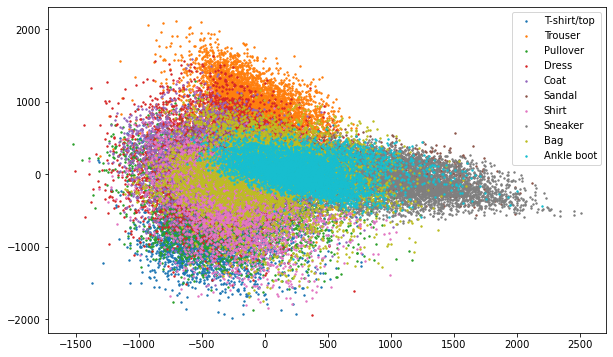

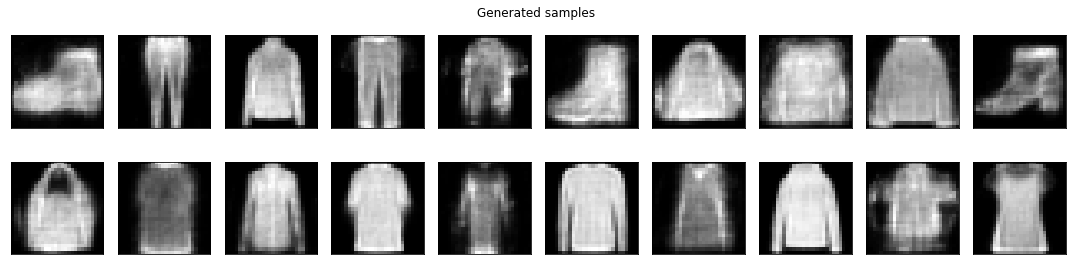

Epoch: 62 | train loss: 0.01952
Epoch: 63 | train loss: 0.01955
Epoch: 64 | train loss: 0.01958
Epoch: 65 | train loss: 0.01958
Epoch: 66 | train loss: 0.01951
Epoch: 67 | train loss: 0.01946
Epoch: 68 | train loss: 0.01945
Epoch: 69 | train loss: 0.01944
Epoch: 70 | train loss: 0.01941
Epoch: 71 | train loss: 0.01942


<Figure size 432x288 with 0 Axes>

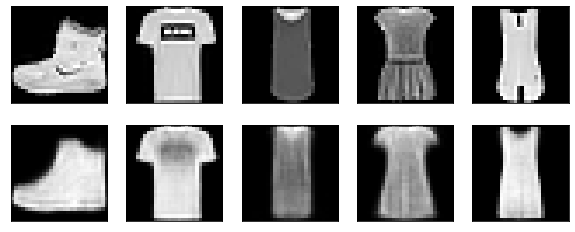

<Figure size 432x288 with 0 Axes>

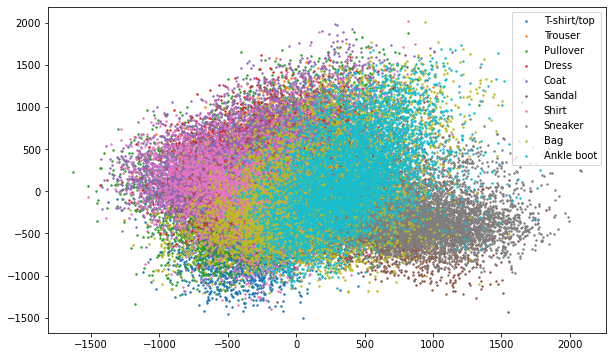

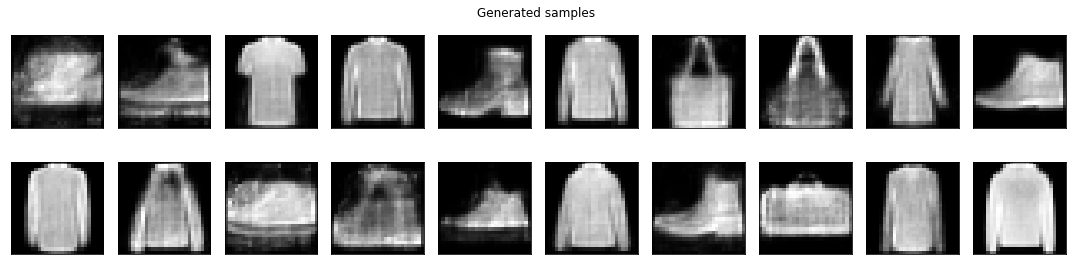

Epoch: 72 | train loss: 0.01934
Epoch: 73 | train loss: 0.01942
Epoch: 74 | train loss: 0.01930
Epoch: 75 | train loss: 0.01939
Epoch: 76 | train loss: 0.01930
Epoch: 77 | train loss: 0.01940
Epoch: 78 | train loss: 0.01923
Epoch: 79 | train loss: 0.01926
Epoch: 80 | train loss: 0.01923
Epoch: 81 | train loss: 0.01932


<Figure size 432x288 with 0 Axes>

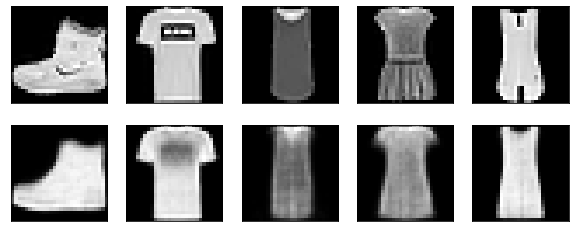

<Figure size 432x288 with 0 Axes>

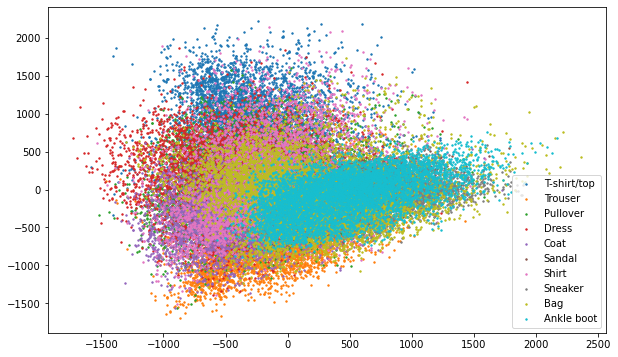

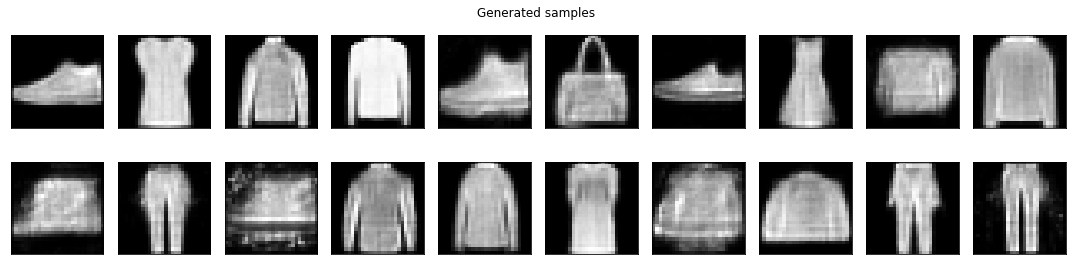

Epoch: 82 | train loss: 0.01921
Epoch: 83 | train loss: 0.01920
Epoch: 84 | train loss: 0.01915
Epoch: 85 | train loss: 0.01914
Epoch: 86 | train loss: 0.01918
Epoch: 87 | train loss: 0.01927
Epoch: 88 | train loss: 0.01922
Epoch: 89 | train loss: 0.01913
Epoch: 90 | train loss: 0.01906
Epoch: 91 | train loss: 0.01909


<Figure size 432x288 with 0 Axes>

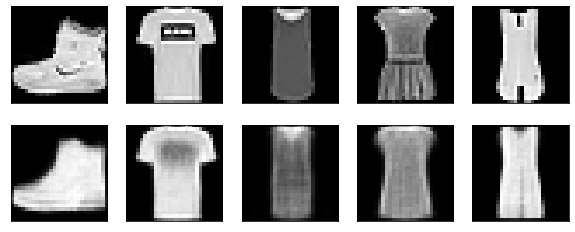

<Figure size 432x288 with 0 Axes>

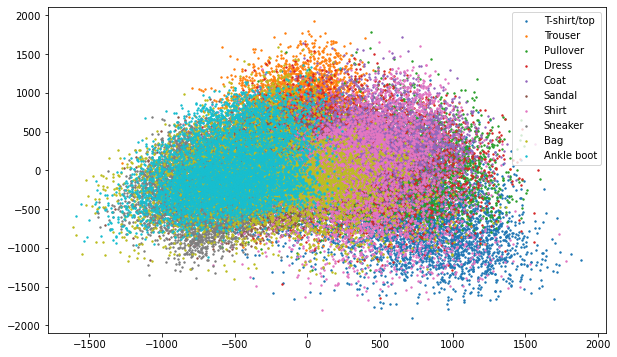

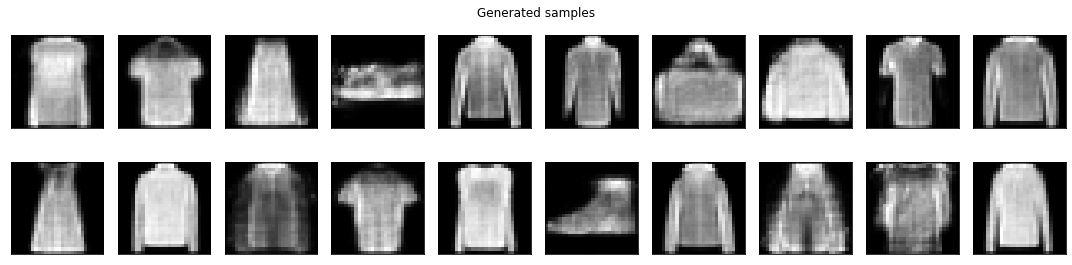

Epoch: 92 | train loss: 0.01912
Epoch: 93 | train loss: 0.01906
Epoch: 94 | train loss: 0.01910
Epoch: 95 | train loss: 0.01899
Epoch: 96 | train loss: 0.01900
Epoch: 97 | train loss: 0.01896
Epoch: 98 | train loss: 0.01896
Epoch: 99 | train loss: 0.01896
Epoch: 100 | train loss: 0.01894


In [10]:
n_epochs = 100
lr = 5e-3 
latent_dim = 50

wae = WAEMMD(latent_dim).to(device)

optimizer = torch.optim.Adam(wae.parameters(), lr=lr)

sigma = 2 * latent_dim * 0.01
C = 1.

criterion = torch.nn.MSELoss()

for epoch in range(n_epochs):
    epoch_losses = []
    for step, (x, _) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        x = x.to(device)
        
        encoded, decoded = wae(x)

        rec_loss = criterion(decoded, x)
        latent_loss = wae.mmd_loss(encoded, sigma=sigma)
        loss = rec_loss + C * latent_loss

        loss.backward()
        optimizer.step()

        epoch_losses += [loss.item()]

    print(f'Epoch: {epoch+1} | train loss: {np.mean(epoch_losses):.5f}')

    if epoch % 10 == 0:
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)